In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    f1_score,
    recall_score
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


1. Load and Inspect the Data


In [186]:
file_path = "../Data/Challenge_2/UV7581-XLS-ENG.xlsx"
df = pd.read_excel(file_path, sheet_name='Exhibit 1 -- Data')

print(f"\nDataset shape: {df.shape}")
print(f"\nData types: {df.dtypes}")
print(f"\nMissing values: {df.isna().sum()[df.isna().sum() > 0]}")
print("\nTarget variable distribution:")
print(df['Retained.in.2012.'].value_counts(normalize=True))

df = df.dropna(subset=['Retained.in.2012.']).copy()
print(f"\nDataset shape after removing missing target: {df.shape}")



Dataset shape: (2392, 56)

Data types: ID                                        object
Program.Code                              object
From.Grade                               float64
To.Grade                                 float64
Group.State                               object
Is.Non.Annual.                           float64
Days                                     float64
Travel.Type                               object
Departure.Date                    datetime64[ns]
Return.Date                       datetime64[ns]
Deposit.Date                      datetime64[ns]
Special.Pay                               object
Tuition                                  float64
FRP.Active                               float64
FRP.Cancelled                            float64
FRP.Take.up.percent.                     float64
Early.RPL                         datetime64[ns]
Latest.RPL                        datetime64[ns]
Cancelled.Pax                            float64
Total.Discount.Pax           

In [187]:
print(f"\nColumns: {df.columns}")


Columns: Index(['ID', 'Program.Code', 'From.Grade', 'To.Grade', 'Group.State',
       'Is.Non.Annual.', 'Days', 'Travel.Type', 'Departure.Date',
       'Return.Date', 'Deposit.Date', 'Special.Pay', 'Tuition', 'FRP.Active',
       'FRP.Cancelled', 'FRP.Take.up.percent.', 'Early.RPL', 'Latest.RPL',
       'Cancelled.Pax', 'Total.Discount.Pax', 'Initial.System.Date',
       'Poverty.Code', 'Region', 'CRM.Segment', 'School.Type',
       'Parent.Meeting.Flag', 'MDR.Low.Grade', 'MDR.High.Grade',
       'Total.School.Enrollment', 'Income.Level', 'EZ.Pay.Take.Up.Rate',
       'School.Sponsor', 'SPR.Product.Type', 'SPR.New.Existing', 'FPP',
       'Total.Pax', 'SPR.Group.Revenue', 'NumberOfMeetingswithParents',
       'FirstMeeting', 'LastMeeting', 'DifferenceTraveltoFirstMeeting',
       'DifferenceTraveltoLastMeeting', 'SchoolGradeTypeLow',
       'SchoolGradeTypeHigh', 'SchoolGradeType', 'DepartureMonth',
       'GroupGradeTypeLow', 'GroupGradeTypeHigh', 'GroupGradeType',
       'MajorProgr

2. Initial set of candidate features

In [188]:
#Initial intuitive choice of features
candidate_features = [
    #Trip/Price related
    'Tuition',
    'Days',
    'SPR.Group.Revenue',
    'Total.Pax',
    #Engagement
    'Parent.Meeting.Flag',
    'NumberOfMeetingswithParents',
    #School characteristics
    'Poverty.Code',
    'Income.Level',
    'Total.School.Enrollment',
    'School.Type',
    'Region',
    #Group characteristics
    'FPP',
    'Is.Non.Annual.',
    #Date
    'Departure.Date'
]

3. Preprocessing and Encoding and Feature Enigneering 

In [189]:
y = df['Retained.in.2012.'].astype(int)
X = df[candidate_features].copy()
print(f"\nInitial feature matrix shape: {X.shape}")

#Handle dates
if 'Departure.Date' in X.columns:
    X['Departure_Month'] = pd.to_datetime(X['Departure.Date']).dt.month
    X = X.drop('Departure.Date', axis=1)

#Poverty.Code (A, B, C, D) -> 1, 2, 3, 4
if 'Poverty.Code' in X.columns:
    poverty_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4}
    X['Poverty.Code'] = X['Poverty.Code'].map(poverty_mapping)

#Income.Level (A-Q) -> 1-17
if 'Income.Level' in X.columns:
    income_mapping = {chr(65+i): i+1 for i in range(17)}
    X['Income.Level'] = X['Income.Level'].map(income_mapping)

#Handle missing values
numeric_cols = X.select_dtypes(include=[np.number]).columns.to_list()
categorical_cols = X.select_dtypes(include=['object']).columns.to_list()

for col in numeric_cols:
    if X[col].isna().sum() > 0:
        median_val = X[col].median()
        X.fillna({col:median_val}, inplace=True)

for col in categorical_cols:
    if X[col].isna().sum() > 0:
        mode_val = X[col].mode()[0]
        X.fillna({col:mode_val}, inplace=True)

#One-hot encoding of nominal variables
nominal_categories = ['School.Type', 'Region']
X = pd.get_dummies(X, columns=nominal_categories, drop_first=True)

#Feature engineering

#Affordability indicators
X['Tuition_x_Income'] = X['Tuition'] * X['Income.Level']
X['Tuition_x_Poverty'] = X['Tuition'] * X['Poverty.Code']

#Trip cost proxy
X['Tuition_x_Days'] = X['Tuition'] * X['Days']

# Engagement intensity
X['ParentMeeting_x_Count'] = X['Parent.Meeting.Flag'] * X['NumberOfMeetingswithParents']

# Participation context
X['FPP_x_Enrollment'] = X['FPP'] * X['Total.School.Enrollment']

# Revenue efficiency
X['Revenue_per_Pax'] = X['SPR.Group.Revenue'] / (X['Total.Pax'] + 1)



Initial feature matrix shape: (2389, 14)


In [190]:
#Verification
print(f"\nFinal feature matrix shape after encoding: {X.shape}")
print(f"Final feature count: {X.shape[1]}")
print("\nFinal feature names:")
print(X.columns.tolist())

print(f"Any missing values? {False if X.isna().sum().sum() == 0 else True}")


Final feature matrix shape after encoding: (2389, 26)
Final feature count: 26

Final feature names:
['Tuition', 'Days', 'SPR.Group.Revenue', 'Total.Pax', 'Parent.Meeting.Flag', 'NumberOfMeetingswithParents', 'Poverty.Code', 'Income.Level', 'Total.School.Enrollment', 'FPP', 'Is.Non.Annual.', 'Departure_Month', 'School.Type_Catholic', 'School.Type_PUBLIC', 'School.Type_Private non-Christian', 'Region_Houston', 'Region_Northern California', 'Region_Other', 'Region_Pacific Northwest', 'Region_Southern California', 'Tuition_x_Income', 'Tuition_x_Poverty', 'Tuition_x_Days', 'ParentMeeting_x_Count', 'FPP_x_Enrollment', 'Revenue_per_Pax']
Any missing values? False


4. Train/Test Split and Scaling

In [191]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

#Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

5. Logisitic Regression with SGD

In [232]:
sgd_logreg = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    alpha=0.01,
    max_iter=1000,
    tol=1e-3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

sgd_logreg.fit(X_train_scaled, y_train)

,loss,'log_loss'
,penalty,'l2'
,alpha,0.01
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,-1


6. Make predictions and Evaluate the model

In [233]:
y_pred = sgd_logreg.predict(X_test_scaled)
y_proba = sgd_logreg.predict_proba(X_test_scaled)[:, 1]

In [234]:
class Performance_Eval:
    def __init__(self, y_pred, y_test, y_proba):
        self.y_pred = y_pred
        self.y_test = y_test
        self.y_proba = y_proba
    
    def _classification_report_generation(self, target_names: list[str]):
        print(classification_report(self.y_test, self.y_pred, target_names=target_names))
    
    def _confusion_matrix_generation(self):
        cm = confusion_matrix(self.y_test, self.y_pred)
        print(cm)
        print("\nConfusion Matrix Breakdown:")
        tn, fp, fn, tp = cm.ravel()
        print(f" True Negatives: {tn}")
        print(f" False Positives: {fp}")
        print(f" False Negatives: {fn}")
        print(f" True Positives: {tp}")
    
    def _performance_metrics(self):
        accuracy = accuracy_score(self.y_test, self.y_pred)
        f1 = f1_score(self.y_test, self.y_pred)
        roc_auc = roc_auc_score(self.y_test, self.y_proba)
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
    
    def _plot_roc_curve(self):
        fpr, tpr, _ = roc_curve(self.y_test, self.y_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, linewidth=2, label='SGD Logistic Regression')
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curve - SGD Logistic Regression', fontsize=14, fontweight='bold')
        plt.legend(loc='lower right')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()



In [235]:
performance_eval_object = Performance_Eval(y_pred, y_test, y_proba)

In [236]:
performance_eval_object._classification_report_generation(target_names=['Not Retained', 'Retained'])

              precision    recall  f1-score   support

Not Retained       0.78      0.52      0.62       188
    Retained       0.74      0.90      0.82       290

    accuracy                           0.75       478
   macro avg       0.76      0.71      0.72       478
weighted avg       0.76      0.75      0.74       478



In [237]:
performance_eval_object._confusion_matrix_generation()

[[ 98  90]
 [ 28 262]]

Confusion Matrix Breakdown:
 True Negatives: 98
 False Positives: 90
 False Negatives: 28
 True Positives: 262


In [238]:
performance_eval_object._performance_metrics()

Accuracy: 0.7531
F1 Score: 0.8162
ROC AUC: 0.8033


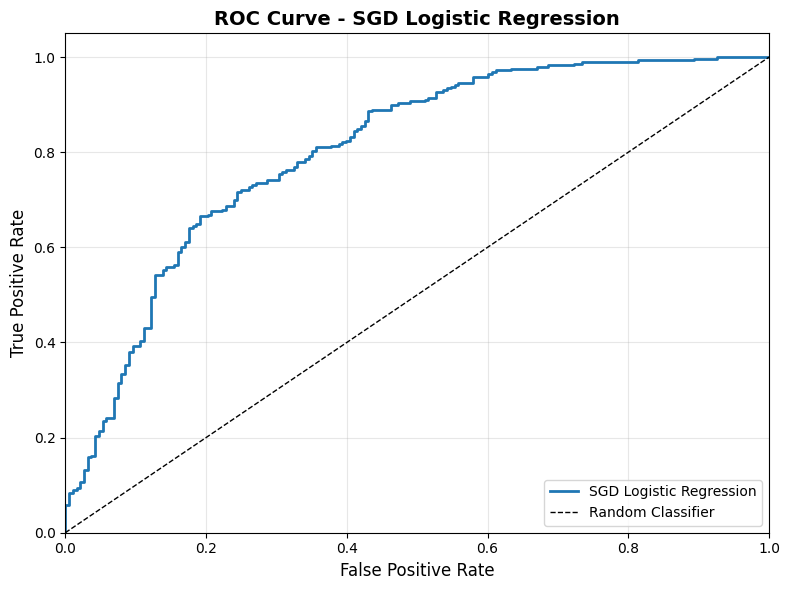

In [239]:
performance_eval_object._plot_roc_curve()

7. Model Improvement

In [240]:
#Smart feature selection
rfe = RFE(sgd_logreg, n_features_to_select=10)
rfe.fit(X_train_scaled, y_train)
selected_features = X_train.columns[rfe.support_]
print(f"Selected features: {selected_features}")

Selected features: Index(['Tuition', 'SPR.Group.Revenue', 'Total.Pax', 'Income.Level', 'FPP',
       'Is.Non.Annual.', 'School.Type_Private non-Christian', 'Tuition_x_Days',
       'FPP_x_Enrollment', 'Revenue_per_Pax'],
      dtype='object')


In [241]:
sgd_logreg_sfs = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    alpha=0.01,
    max_iter=1000,
    tol=1e-3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

In [242]:
#Retrain the model using selected features
X_train_selected = X_train[selected_features].copy()
X_test_selected = X_test[selected_features].copy()

X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)

sgd_logreg_sfs.fit(X_train_selected_scaled, y_train)

,loss,'log_loss'
,penalty,'l2'
,alpha,0.01
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,-1


In [294]:
y_pred_selected = sgd_logreg_sfs.predict(X_test_selected_scaled)
y_proba_selected = sgd_logreg_sfs.predict_proba(X_test_selected_scaled)[:, 1]

#Find the optimal threshold for Macro F1
f1_0_scores = []
f1_1_scores = []
threshold_range = np.linspace(0.1, 0.9, 100) 

for t in threshold_range:
    preds_temp = (y_proba_selected >= t).astype(int)
    f1_0_scores.append(f1_score(y_test, preds_temp, pos_label=0, zero_division=0))
    f1_1_scores.append(f1_score(y_test, preds_temp, pos_label=1, zero_division=0))
    
f1_macro_avg = (np.array(f1_0_scores) + np.array(f1_1_scores)) / 2

best_index = np.argmax(f1_macro_avg)
best_threshold = threshold_range[best_index]

print(f"Found new optimal threshold for Macro F1: {best_threshold:.4f}")

y_pred_tuned = (y_proba_selected >= best_threshold).astype(int)

performance_eval_selected_object = Performance_Eval(y_pred_tuned, y_test, y_proba_selected)

Found new optimal threshold for Macro F1: 0.5768


In [282]:
performance_eval_selected_object._classification_report_generation(target_names=['Retained', 'Not Retained'])

              precision    recall  f1-score   support

    Retained       0.71      0.63      0.66       188
Not Retained       0.77      0.83      0.80       290

    accuracy                           0.75       478
   macro avg       0.74      0.73      0.73       478
weighted avg       0.75      0.75      0.75       478



In [283]:
performance_eval_selected_object._confusion_matrix_generation()

[[118  70]
 [ 49 241]]

Confusion Matrix Breakdown:
 True Negatives: 118
 False Positives: 70
 False Negatives: 49
 True Positives: 241


In [284]:
performance_eval_selected_object._performance_metrics()

Accuracy: 0.7510
F1 Score: 0.8020
ROC AUC: 0.8011


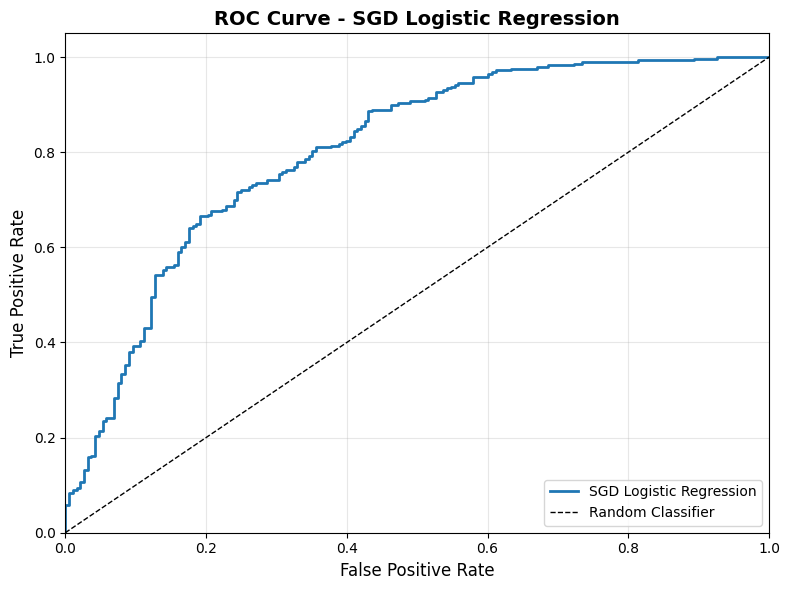

In [285]:
performance_eval_object._plot_roc_curve()

8.Model coefficients

In [254]:
coefficients = sgd_logreg_sfs.coef_[0]
feature_names = X_test_selected.columns

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coef_df

,Feature,Coefficient
0,Tuition,0.180854
1,SPR.Group.Revenue,0.180854
2,Total.Pax,0.175594
3,Income.Level,0.234457
4,FPP,0.151358
5,Is.Non.Annual.,-0.846593
6,School.Type_Private non-Christian,0.185640
7,Tuition_x_Days,-0.261977
8,FPP_x_Enrollment,0.300014
9,Revenue_per_Pax,-0.473383


9. Supporting Graphs

Text(0.5, 1.0, 'Feature correlation Heatmap')

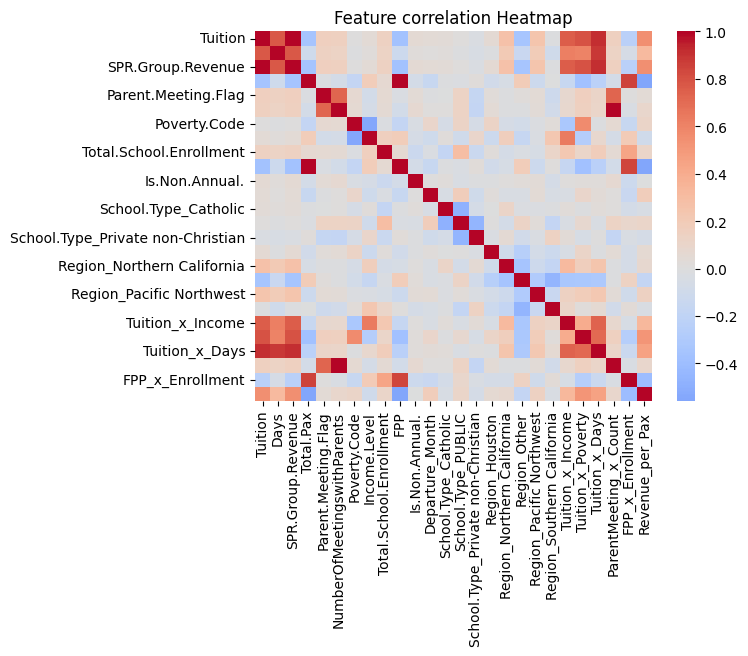

In [256]:
sns.heatmap(X.corr(), cmap="coolwarm", center=0)
plt.title("Feature correlation Heatmap")

Text(0.5, 1.0, 'Feature correlation Heatmap post RFE')

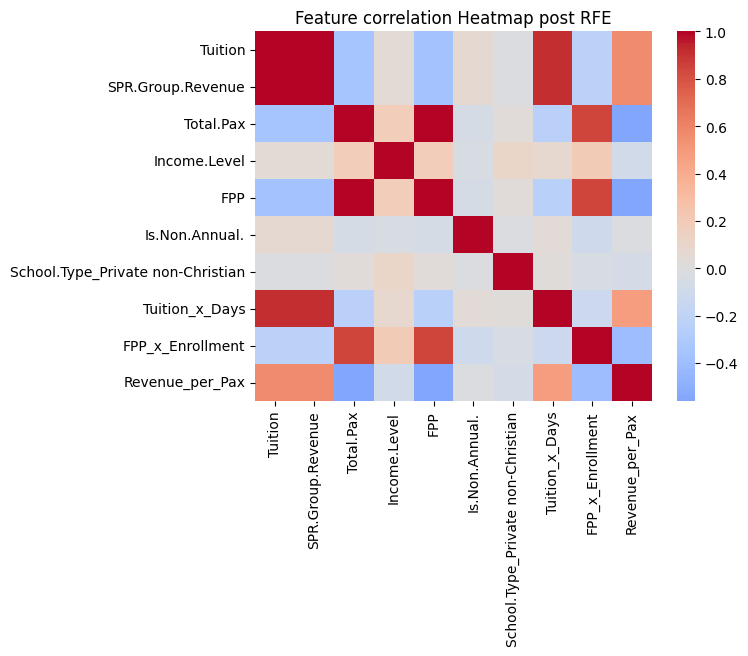

In [258]:
sns.heatmap(X_train_selected.corr(), cmap="coolwarm", center=0)
plt.title("Feature correlation Heatmap post RFE")

Text(0.5, 0, 'Absolute Coefficient Value')

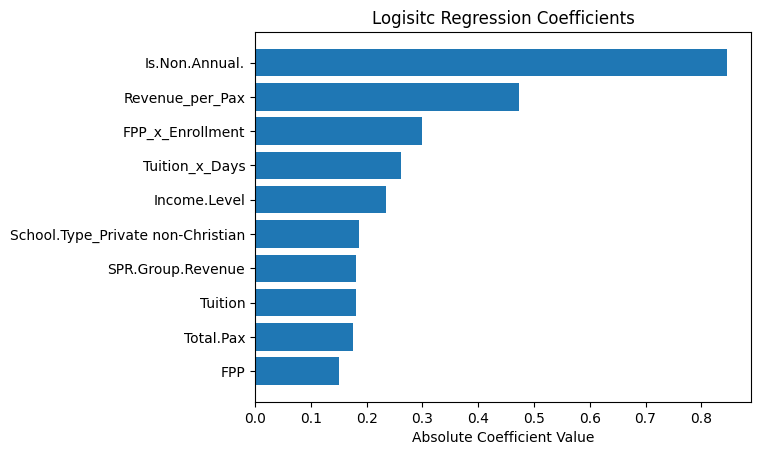

In [261]:
coef_df['AbsCoeff'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('AbsCoeff', ascending=True)
plt.barh(coef_df['Feature'], coef_df['AbsCoeff'])
plt.title('Logisitc Regression Coefficients')
plt.xlabel('Absolute Coefficient Value')

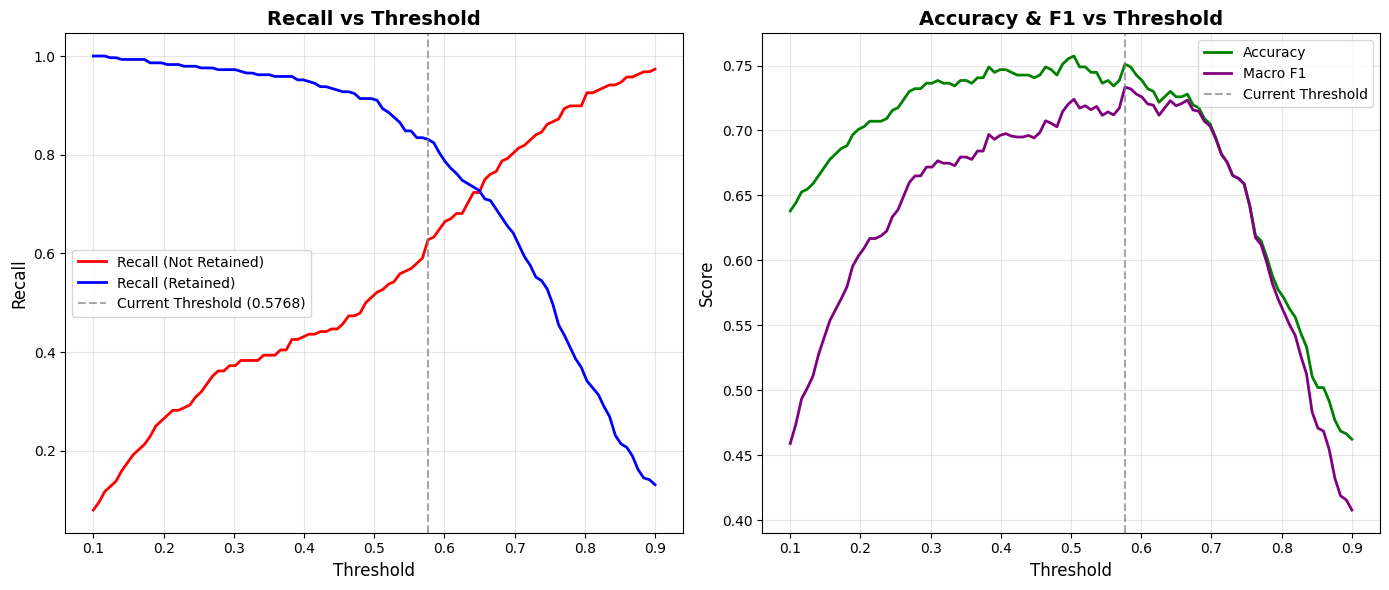

In [293]:
threshold_range = np.linspace(0.1, 0.9, 100)
recall_0_list = []
recall_1_list = []
accuracy_list = []
f1_macro_list = []

for t in threshold_range:
    preds = (y_proba_selected >= t).astype(int)
    recall_0_list.append(recall_score(y_test, preds, pos_label=0, zero_division=0))
    recall_1_list.append(recall_score(y_test, preds, pos_label=1, zero_division=0))
    accuracy_list.append(accuracy_score(y_test, preds))
    f1_0 = f1_score(y_test, preds, pos_label=0, zero_division=0)
    f1_1 = f1_score(y_test, preds, pos_label=1, zero_division=0)
    f1_macro_list.append((f1_0 + f1_1) / 2)

plt.figure(figsize=(14, 6))

# Plot 1: Recalls
plt.subplot(1, 2, 1)
plt.plot(threshold_range, recall_0_list, label='Recall (Not Retained)', linewidth=2, color='red')
plt.plot(threshold_range, recall_1_list, label='Recall (Retained)', linewidth=2, color='blue')
plt.axvline(0.5768, color='gray', linestyle='--', alpha=0.7, label='Current Threshold (0.5768)')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.title('Recall vs Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Plot 2: Accuracy and F1
plt.subplot(1, 2, 2)
plt.plot(threshold_range, accuracy_list, label='Accuracy', linewidth=2, color='green')
plt.plot(threshold_range, f1_macro_list, label='Macro F1', linewidth=2, color='purple')
plt.axvline(0.5768, color='gray', linestyle='--', alpha=0.7, label='Current Threshold')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Accuracy & F1 vs Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
